In [1]:
import numpy as np
import pandas as pd
import spacy
import glob 
import pyLDAvis
import pyLDAvis.sklearn
from wordcloud import WordCloud, STOPWORDS
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm import tqdm
import matplotlib.pyplot as plt
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from spacy.lang.nl.stop_words import STOP_WORDS
from string import punctuation
from heapq import nlargest
from spacy.lang.nl import Dutch

C:\Users\sebas\anaconda3\envs\nlp\lib\site-packages\past\builtins\misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [49]:
def loadLangModel(lang):
    """
    This function loads a spacy model and return it.
    """
    return spacy.load(lang)

In [50]:
# load a medium sized dutch language model in spacy
#nlp = loadLangModel('nl_core_news_md')
nlp = loadLangModel('nl_core_news_lg')

#### Functions for word frequencie, percentage importance, entities visualization, POS and summarization of text

In [51]:
stopwords = list(STOP_WORDS)

In [52]:
#Using spaCy's built-in visualizer to detect named entities in the document
def visualizeEntities(doc):
    """
    This function uses displacy from spaCy to show named entities of a document
    """
    displacy.render(doc, style="ent", jupyter=True)
    

In [53]:
#Calculating word frequencies from the text after removing stopwords and puntuactions:
def displayWordFrequencies(doc, stopwords):
    """
    this function returns word frequenties and should be given a doc and the stopwords corresponding to the imported language
    in spacy
    For example in Dutch:
    from spacy.lang.nl.stop_words import STOP_WORDS
    """
    #First lemmatize the doc
    doc = str(" ".join([i.lemma_ for i in doc]))
    doc = nlp(doc)
    word_frequencies={}
    for word in doc:
        if word.text.lower() not in stopwords:
            if word.text.lower() not in punctuation:
                if word.text not in word_frequencies.keys():
                    word_frequencies[word.text] = 1
                else:
                    word_frequencies[word.text] += 1
    return word_frequencies

In [54]:
#Calculate the maximum frequency and divide it by all frequencies to get normalized word frequencies.
def percentageImportance(word_frequencies):
    """
    This function returns the word importance percentage, we must pass word frequencie first 
    """
    max_frequency=max(word_frequencies.values())
    for word in word_frequencies.keys():
        word_frequencies[word]=(word_frequencies[word]/max_frequency)
    
    
    return word_frequencies

In [55]:
#Ref for attempting summarization https://www.numpyninja.com/post/text-summarization-through-use-of-spacy-library
def createSummary(doc, word_frequencies):
    """
    this function creates a summary of the given text
    """
    #Get sentence tokens 
    sentence_tokens= [sent for sent in doc.sents]
    #Calculate the most important sentences by adding the word frequencies in each sentence.
    sentence_scores = {}
    for sent in sentence_tokens:
        for word in sent:
            if word.text.lower() in word_frequencies.keys():
                if sent not in sentence_scores.keys():                            
                 sentence_scores[sent]=word_frequencies[word.text.lower()]
                else:
                 sentence_scores[sent]+=word_frequencies[word.text.lower()]
    
    #From headhq import nlargest and calculate  30% of text with maximum score.
    select_length=int(len(sentence_tokens)*0.3)
    select_length
    summary=nlargest(select_length, sentence_scores,key=sentence_scores.get)
    summary
    #Get the final summary of text
    final_summary=[word.text for word in summary]
    final_summary
    summary=''.join(final_summary)
    
    return summary
                


In [56]:
def showPOS(doc):
    """
    This function shows parts of speech tagging for a text
    """
    
    for i in nlp(doc):
        print(i, "=>", i.pos_)

### Creating a dataframe from files

In [57]:
#all the texts together
def createDF(path):
    """
    This function receives a path where files and merge the files into a dataframe
    
    """

    path = path
    dataframes = []
    df = pd.DataFrame(columns = ["article_content"])

    for file in glob.glob(path):
        with open(file, encoding='utf-8', errors='ignore') as file_in:
            dataframe = file_in.read().replace('\n', '')
            dataframes.append(dataframe)
    to_append = dataframes
    my_series = pd.Series(to_append)
    df["article_content"]= my_series
    
    return df


In [82]:
#df = createDF('clean_text_nl/*.txt')
df = createDF('final_text/*.txt')

In [83]:
df.head()

,article_content
0,dienst reglementering akkoord onderling overle...
1,houden fiscaal fraudebestrijdend financieel di...
2,bijzonder macht houden afwijking bepaling stur...
3,uitstel bij_staan toezending goedkeuring jaarr...
4,algemeen verbinden verklaren collectief arbeid...


In [60]:
#ref: https://stackoverflow.com/questions/45605946/how-to-do-text-pre-processing-using-spacy
stopwords = list(STOP_WORDS)
punctuations = punctuation
def normalize(comment, lowercase, remove_stopwords):
    """
    This function is used to normalize the text, lemmatize, remove stopwords and punctuations
    
    """
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        #Lemmatize the word
        lemma = word.lemma_.strip()
        if lemma:
            #Remove stopwords and punctuactions
            if not remove_stopwords or (remove_stopwords and lemma not in stopwords and lemma not in punctuations):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

#### Creating a column processed content with normalized article text

In [61]:
tqdm.pandas()
df["processed_content"] = df["article_content"].progress_apply(normalize, lowercase=True, remove_stopwords=True)

100%|██████████| 673/673 [03:10<00:00,  3.53it/s]


In [62]:
df

,article_content,processed_content
0,Dienst Reglementering. - Akkoord in onderling ...,dienst reglementering akkoord onderling overle...
1,"Wet houdende fiscale, fraudebestrijdende, fina...",wet houdende fiscaal fraudebestrijdend financi...
2,Decreet houdende bekrachtiging van de besluite...,decreet houdende bekrachtiging besluit Waals r...
3,Dienst Reglementering. - Akkoord in onderling ...,dienst reglementering akkoord onderling overle...
4,Bijzondere machtenbesluit van de Brusselse Hoo...,bijzonder machtenbesluit Brussels hoofdstedeli...
...,...,...
668,Wet houdende diverse dringende fiscale bepalin...,wet houdende divers dringend fiscaal bepaling ...
669,Selectienummer: AFG20033 Deze selectie werd af...,selectien_ummer afg20033 selectie af_sluiten 2...
670,Selectienummer: ANG21030 Solliciteren kan tot ...,selectien_ummer ang21030 solliciteren 06/04/20...
671,Besluit van de Vlaamse Regering tot wijziging ...,besluit Vlaams regering wijziging besluit Vlaa...


In [84]:
#Example using one processed article in the dataframe. Here we can modify to explore result on other articles
#doc = nlp(df["processed_content"][7])
doc = nlp(df["article_content"][7])

#### Parts of Speech tagging of one article content

In [85]:
showPOS(doc)

houden => VERB
wijziging => NOUN
ministerieel => NOUN
houden => VERB
dringend => ADJ
maatregel => NOUN
verspreiding => NOUN
coronavirus => NOUN
covi_d => ADJ
beperken => VERB
addendum => PROPN
Belgisch => ADJ
bladzijde => NOUN
officieel => ADJ
advies => NOUN
raad => NOUN
toe_voegen => NUM
raad => NOUN
state => SYM
afdeling => NOUN
wetgeving => NOUN
advies => NOUN
ontwerp => NOUN
ministerieel => NOUN
houden => VERB
wijziging => NOUN
ministerieel => NOUN
houden => VERB
dringend => ADJ
maatregel => NOUN
verspreiding => NOUN
coronavirus => NOUN
covi_d => ADJ
beperken => VERB
raad => NOUN
state => PROPN
afdeling => NOUN
wetgeving => NOUN
minister => NOUN
binnenlands => ADV
zaak => NOUN
institutioneel => ADJ
hervorming => NOUN
democratisch => ADJ
vernieuwing => ADJ
verzoeken => NOUN
termijn => NOUN
werkdag => NOUN
verlengen => VERB
werkdag => NOUN
advies => NOUN
verstrekken => VERB
ontwerp => NOUN
ministerieel => NOUN
houden => VERB
wijziging => NOUN
ministerieel => NOUN
houden => VERB
dring

#### Showing Word frequencie with preprocessed text files in dataframe

In [86]:
#Print and see word frequencies to know important words, displaying sorted
word_frequencies = displayWordFrequencies(doc, stopwords)
w_sorted_keys = sorted(word_frequencies, key=word_frequencies.get, reverse=True)
for w in w_sorted_keys:
    print(w, word_frequencies[w])

maatregel 84
ontwerp 56
bevoegdheid 56
ministerieel 53
minister 37
federaal 37
algemeen 36
overheid 34
bepaling 32
civiel 31
lid 30
zaak 27
advies 26
volgen 26
nemen 23
persoon 22
bescherming 22
raad 21
politie 19
bepalen 17
kader 17
afdeling 16
geval 15
overleg 15
binnenlands 14
twee 14
proef 14
veiligheid 14
openbaar 14
sanitair 14
houden 13
verschillend 13
plaats 13
vergadering 12
beginsel 12
overlegcomit 12
aanhef 12
artikel 12
bijzonder 12
wijziging 11
dringend 11
wetgeving 11
rechtsgr_ond 11
betreffen 11
voorwaarde 11
pilootproject 11
toepassing 11
dienen 11
beperken 10
regel 10
economisch 10
grond 10
verwijzen 10
vast_stellen 10
orde 10
bevolking 10
covi_d 9
nieuw 9
dag 9
opmerking 9
omstandigheid 9
betrekking 9
dergelijk 9
grond_gebied 9
gemeente 9
bestuurlijk 9
verplichten 9
zien 9
contact 9
verlengen 8
dienst 8
laten 8
wetsbepaling 8
verband 8
burgemeester 8
zin 8
maken 8
voornoemd 8
epidemisch 8
besmetting 8
adv 8
state 7
termijn 7
vraag 7
bestaan 7
organiseren 7
protocol 7


#### Creating a summary for one article content

In [87]:
summary = createSummary(doc,word_frequencies)
summary

'zin definieren voorontwerp aangehalen wetsbepaling algemeen vergadering afdeling bestuursrechtspraak kader vordering schorsing uiterst dringend noodzakelijkheid context covid pandemie volgen opgemerken lid oorlog_tijd vrede_tijd gelden organiseren minister binnenlands zaak middel lokt maatregel geheelland grond_gebied nodig civiel bescherming cordineren voorbereidinggrond_gebied verschillend ministerieel departement openbaar lichaam raad state menen betwijfelen dergelijk algemeen bepaling steunen ambtenaar ministerieel departement bevoegdheid verlenen opsporing vaststelling inbreuken ministerieel raadzaam rechtsgrond crerenstrikt beperken blijven wijzigingsbepalingen voor_leggen vooropgestelde toepassingstermijn ministerieel periode betrekking wijziging ministerieel kwestie aan_brengen volledig verlengen ontwerp algemeen opmerkingenrechtsgrond luidens aanhef ontwerp rechtsgr_ond zoeken civiel beschermingraad state afdeling wetgeving advies ontwerp ministerieel houden wijziging ministe

#### Showing Percentage importance with preprocessed text files in dataframe

In [88]:
#Showing percentage importance in descending order
per_importance = percentageImportance(word_frequencies)
w_sorted_keys = sorted(per_importance, key=per_importance.get, reverse=True)
for w in w_sorted_keys:
    print(w, "{:.0%}".format(per_importance[w]))

maatregel 100%
ontwerp 67%
bevoegdheid 67%
ministerieel 63%
minister 44%
federaal 44%
algemeen 43%
overheid 40%
bepaling 38%
civiel 37%
lid 36%
zaak 32%
advies 31%
volgen 31%
nemen 27%
persoon 26%
bescherming 26%
raad 25%
politie 23%
bepalen 20%
kader 20%
afdeling 19%
geval 18%
overleg 18%
binnenlands 17%
twee 17%
proef 17%
veiligheid 17%
openbaar 17%
sanitair 17%
houden 15%
verschillend 15%
plaats 15%
vergadering 14%
beginsel 14%
overlegcomit 14%
aanhef 14%
artikel 14%
bijzonder 14%
wijziging 13%
dringend 13%
wetgeving 13%
rechtsgr_ond 13%
betreffen 13%
voorwaarde 13%
pilootproject 13%
toepassing 13%
dienen 13%
beperken 12%
regel 12%
economisch 12%
grond 12%
verwijzen 12%
vast_stellen 12%
orde 12%
bevolking 12%
covi_d 11%
nieuw 11%
dag 11%
opmerking 11%
omstandigheid 11%
betrekking 11%
dergelijk 11%
grond_gebied 11%
gemeente 11%
bestuurlijk 11%
verplichten 11%
zien 11%
contact 11%
verlengen 10%
dienst 10%
laten 10%
wetsbepaling 10%
verband 10%
burgemeester 10%
zin 10%
maken 10%
voorno

#### Visualizing entities of one preprocessed text file in dataframe with spaCy

In [89]:
visualizeEntities(doc)

### Topic-modeling

In [70]:
# Creating a vectorizer
vectorizer = CountVectorizer(min_df=5, max_df=0.9, stop_words=stopwords, lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}')
data_vectorized = vectorizer.fit_transform(df["processed_content"])

In [90]:
#Using tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words=stopwords)
#tfidf = tfidf_vectorizer.fit_transform(df["processed_content"])
tfidf = tfidf_vectorizer.fit_transform(df["article_content"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [91]:
NUM_TOPICS = 10

In [92]:
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10


### Calculating LDA

In [93]:
# Functions for printing keywords for each topic
topic_num = 10
def selected_topics(model, vectorizer, top_n=topic_num):
    """
    This function prints on screen the keywords of each topic, we can pass the number of topics
    """
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names_out()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [94]:
# Keywords for topics clustered by Latent Dirichlet Allocation
print("LDA Model:")
selected_topics(lda, tfidf_vectorizer, 10)

LDA Model:
Topic 0:
[('apotheek', 315.3411006614167), ('baseren', 313.01469168994277), ('adviseur', 298.145294060778), ('geboortedatum', 236.94831722998168), ('actieplan', 229.14648935416344), ('aanvankelijk', 214.81888379817494), ('decembren', 204.9080570504882), ('liren', 202.84076000253157), ('bekomen', 201.01312675729298), ('afwijkingsregeling', 186.6973920818723)]
Topic 1:
[('ambivalentie', 2000.7152815056827), ('gezondheidszorgsy_teem', 1406.8583041981292), ('bekrachtigen', 1291.5287391397628), ('dimensie', 1267.889280685806), ('kuurne', 1147.9982933235324), ('activiteitsur', 998.4128199903184), ('beginsel', 873.5194512850649), ('dwingen', 863.2157605830439), ('borgstelling', 853.177570580563), ('farmaceutisch', 715.8368605709665)]
Topic 2:
[('dimensie', 2248.3768896539545), ('location', 2128.402504314118), ('afbetalings_plan', 1691.9418221392684), ('activiteitsur', 1459.943286721731), ('ambivalentie', 1444.331380670721), ('loonmassa', 1360.4099398748942), ('locator', 1352.216652

### Calculating NMF

In [95]:
# Non-Negative Matrix Factorization Model
nmf = NMF(n_components=NUM_TOPICS)
data_nmf = nmf.fit_transform(data_vectorized) 

In [96]:
# Keywords for topics clustered by Non-Negative Matrix Factorization

print("NMF Model:")
selected_topics(nmf, tfidf_vectorizer)

NMF Model:
Topic 0:
[('ambivalentie', 21.325038497699026), ('derdebetalersregeling', 12.805031873678795), ('beginsel', 10.157345014297865), ('doelpo_pulatie', 9.330512529762817), ('individueel', 7.909661528743892), ('decembren', 7.03053254894604), ('location', 6.671340852258859), ('bekomen', 6.590449490712867), ('doeltreffend', 6.534649776088787), ('dierenwelzijnclerfayt', 6.199391656126553)]
Topic 1:
[('categorien', 11.24191171868415), ('locator', 10.171910957606196), ('afbetalings_plan', 9.706911197179833), ('dimensie', 8.699984861329103), ('ambivalentie', 7.440793768053153), ('evaluatie', 7.131219276790255), ('derdebetalersregeling', 6.932531633163619), ('gezondheidszorgberoep', 6.496932124950365), ('dimona', 6.393574295510116), ('aftrek', 6.3124462326071455)]
Topic 2:
[('location', 22.154952390394126), ('loonmassa', 13.858478978056691), ('activiteitsur', 13.528869350410844), ('kleding', 10.816533966636971), ('dranken', 5.610840063367159), ('loisir', 5.17476022777987), ('kwijtgescho

### Using Latent Semantic Indexing Model using Truncated SVD

In [97]:
lsi = TruncatedSVD(n_components=NUM_TOPICS)
data_lsi = lsi.fit_transform(data_vectorized)

In [98]:
# Keywords for topics clustered by Latent Semantic Indexing
print("LSI Model:")
selected_topics(lsi, tfidf_vectorizer)

LSI Model:
Topic 0:
[('dimensie', 0.2984297705525912), ('ambivalentie', 0.29640392570944), ('location', 0.24085078515969155), ('afbetalings_plan', 0.2302637442994468), ('activiteitsur', 0.19307817380398462), ('anticiperen', 0.14768392916997086), ('beginsel', 0.14508708541870655), ('derdebetalersregeling', 0.14367431272091535), ('locator', 0.1373539683028019), ('categorien', 0.13681060924402563)]
Topic 1:
[('categorien', 0.2902876533223278), ('locator', 0.26955995553682544), ('dimona', 0.1757330000379612), ('aftrek', 0.16777430862660245), ('gezondheidszorgberoep', 0.15901916669582808), ('afval', 0.15320306275218773), ('derdebetalersregeling', 0.15306879396365447), ('afbetalings_plan', 0.14140359407898764), ('attentie', 0.13651313567657142), ('afwijkingsregeling', 0.13143424203633247)]
Topic 2:
[('location', 0.5170914640510552), ('loonmassa', 0.36082489527268563), ('activiteitsur', 0.2557242649257174), ('kleding', 0.24500968761303385), ('bekomen', 0.13116826848605947), ('dranken', 0.1175

### Visualizing LDA results with pyLDAvis

In [99]:
def visualizeLDA(model):
    """
    This function displays LDA with pyLDAvis
    """ 
    pyLDAvis.enable_notebook()
    dash = pyLDAvis.sklearn.prepare(model, data_vectorized, vectorizer, mds='tsne')
    return dash

In [100]:
dash = visualizeLDA(lda)
dash

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
3      32.420952   8.115230       1        1  34.343022
2       0.648955  71.707100       2        1  21.468277
1      71.019684   9.971006       3        1  15.778095
9       3.785981  33.185135       4        1   6.990615
8     -42.666500  -9.222070       5        1   5.110623
5      -3.621689 -43.526516       6        1   5.073756
4      -3.632402  -4.171708       7        1   4.569898
7     -36.584400  35.804413       8        1   3.544403
0      44.391380  50.615383       9        1   3.039366
6      40.235809 -31.591665      10        1   0.081945, topic_info=             Term         Freq        Total Category  logprob  loglift
3279     regering  3160.000000  3160.000000  Default  30.0000  30.0000
3028      persoon  1946.000000  1946.000000  Default  29.0000  29.0000
755      brussels  1331.000000  1331.000000  Default  28.0000  28.0000
569       besluit  8403.000000  8403.000000  Default  27.0000  27.0000
387      bedoelen  3909.000000  3909.000000  Default  26.0000  26.0000
...           ...          ...          ...      ...      ...      ...
798       centrum     0.070424   904.849529  Topic10  -8.6252  -2.3541
4678          wet     0.074921  4593.730445  Topic10  -8.5633  -3.9169
3028      persoon     0.072344  1946.581640  Topic10  -8.5983  -3.0933
933        covid-     0.073027  4637.471038  Topic10  -8.5889  -3.9520
923   coronavirus     0.070978  1500.692039  Topic10  -8.6173  -2.8522

[748 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
11        7  0.963020       -patint
12        1  0.063222     -patinten
12        7  0.885106     -patinten
23        1  0.003130       aandeel
23        2  0.785589       aandeel
...     ...       ...           ...
4785      7  0.518057          zorg
4790      1  0.080356  zorgverlener
4790      7  0.910703  zorgverlener
4797      1  0.069319    zuurstofth
4797      7  0.901144    zuurstofth

[2158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 10, 9, 6, 5, 8, 1, 7])

In [44]:
#ref https://ratulesrar3.github.io/sotu-approval-analysis/
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [101]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        data = ' '.join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        title = 'Topic {}'.format(topic_idx+1)
        show_wordcloud(data, title)   

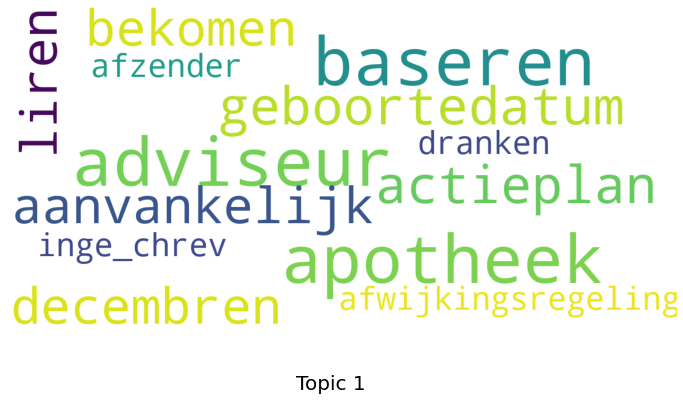

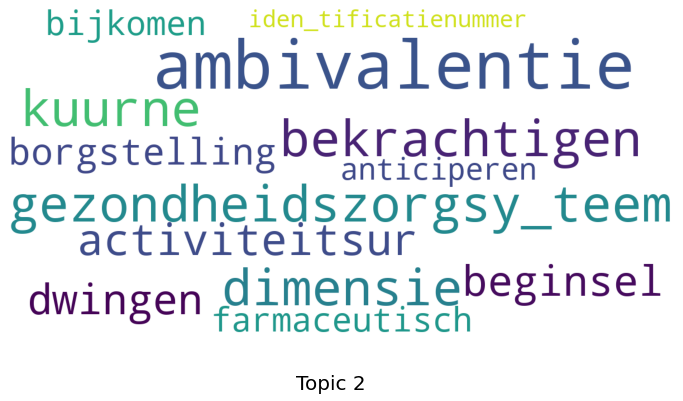

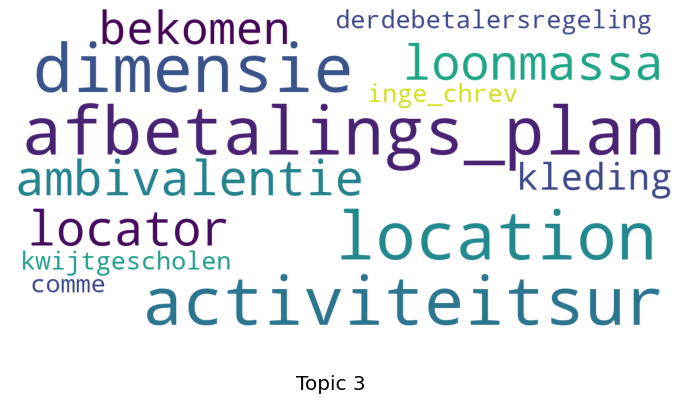

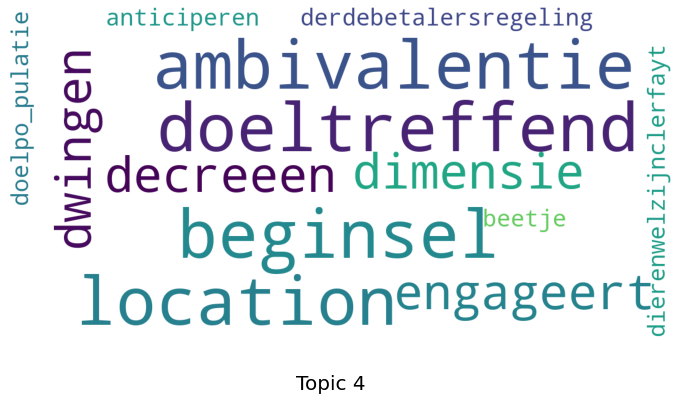

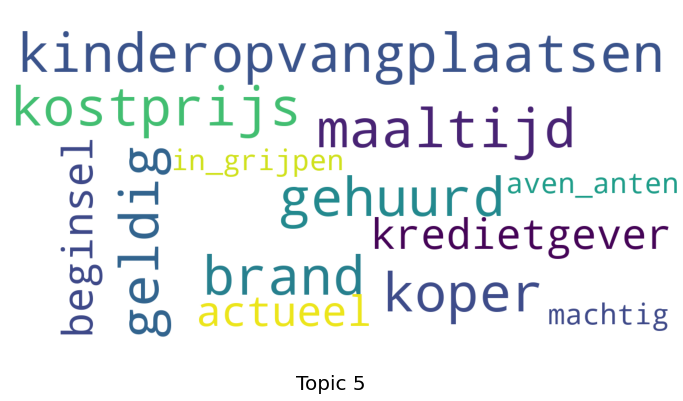

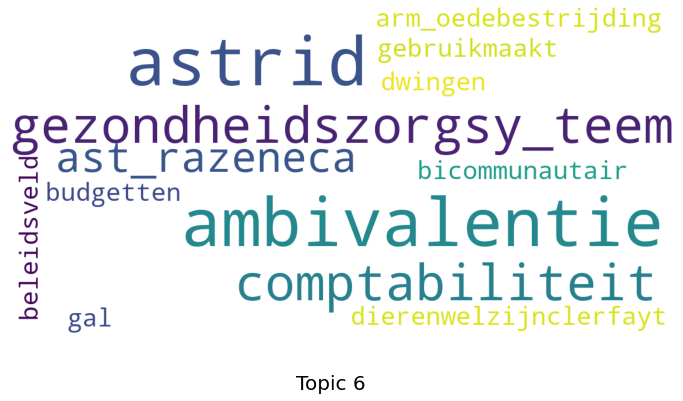

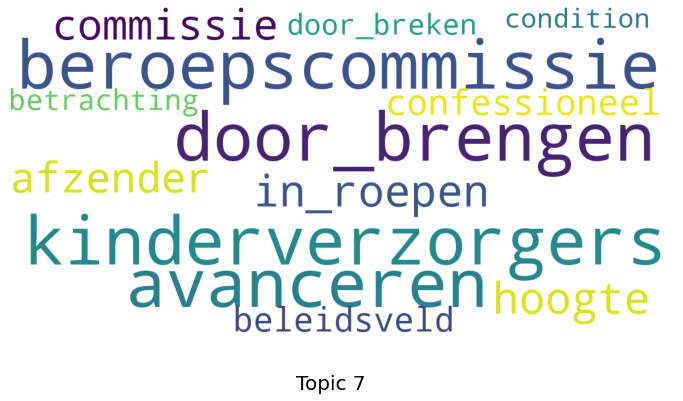

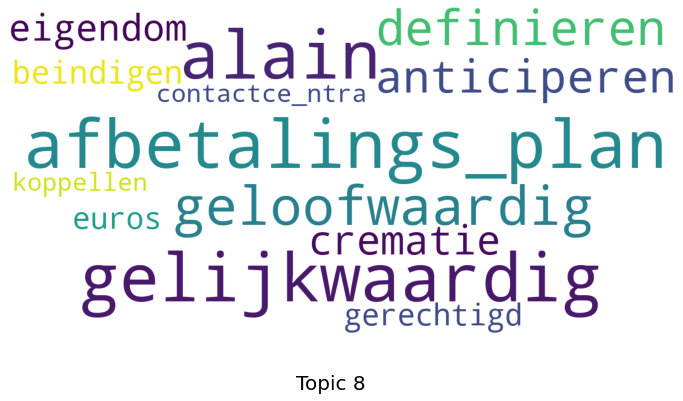

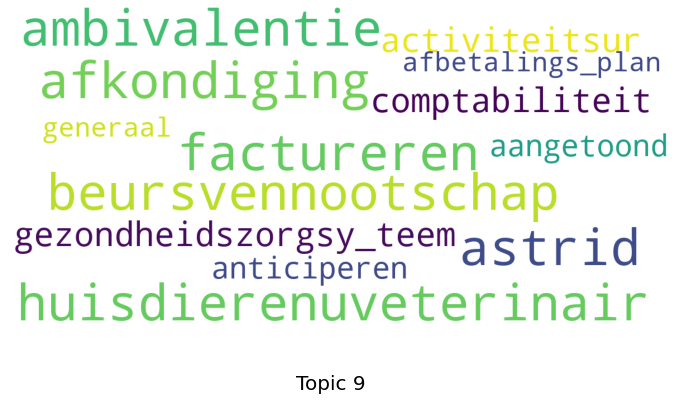

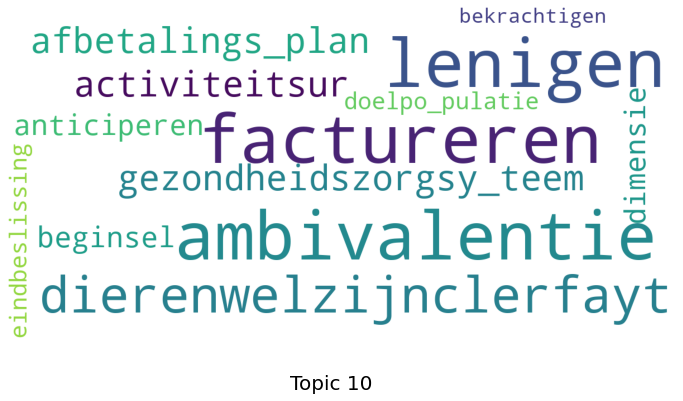

In [102]:
no_top_words = 13
display_topics(lda, tfidf_feature_names, no_top_words)